In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import host, user, password
import acquire
import prepare

## Acquire Data

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    df = pd.read_sql(sql_query, get_connection('telco_churn'))

In [4]:
def get_telco_data():
    '''
    This function reads in iris data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df

In [5]:
df = acquire.get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [9]:
def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('------------------------')
    print(df.info())
    print('------------------------')
    print(df.head())
    
    
summarize_df(df)

This dataframe has 7043 rows and 24 columns.
------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object

# WHO is churning?

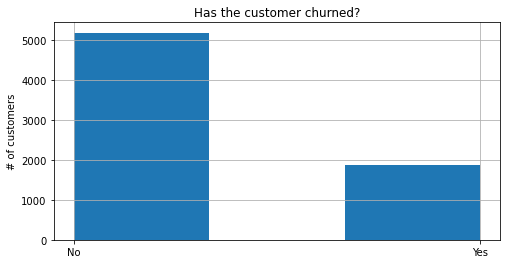

In [10]:
# plot churn
plt.figure(figsize = (8,4))
df.churn.hist(bins=3, align='mid')
plt.title('Has the customer churned?')
plt.ylabel('# of customers')
plt.show()
churn_count = df[df.churn == 'Yes'].churn.count()

In [19]:
print(f'Pecentage of customers who churn: {100*(churn_count/df.churn.count()):.1f}%')

Pecentage of customers who churn: 26.5%


## Prepare Data

In [11]:
# ALWAYS check for nulls

df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [12]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs. It is an all-in-all function.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn_encoded)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_encoded)
    return train, validate, test

In [13]:
def prep_telco_data(df):
        
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
    
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    
    #readability
    df.rename(columns = {'internet_service_type_Fiber optic':'fiber_optic'}, inplace = True)
    df.rename(columns = {'payment_type_Electronic check':'electronic_check'}, inplace = True)

    # Drop duplicate columns
    # Also dropping columns that won't be of use in this case, aka numeric

    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)
      
    # split the data
    train, validate, test = split_telco_data(df)
    
    return train, validate, test

In [14]:
train, validate, test = prep_telco_data(df)

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 47)
validate -> (1688, 47)
test -> (1407, 47)


In [15]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),electronic_check,payment_type_Mailed check
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,1,0,0,0,1,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,1,0,1,0,1,0,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,1,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,0,1
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1


In [16]:
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,fiber_optic,internet_service_type_None,payment_type_Credit card (automatic),electronic_check,payment_type_Mailed check
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,0.161290,32.775210,64.805131,2316.775641,0.498095,0.485141,0.302769,0.905258,0.590297,0.265685,...,0.386335,0.220218,0.391415,0.207010,0.243078,0.437389,0.220218,0.227330,0.327407,0.226314
std,0.367845,24.709604,30.294804,2284.984394,0.500060,0.499843,0.459514,0.292896,0.491841,0.441753,...,0.486971,0.414447,0.488129,0.405215,0.428997,0.496127,0.414447,0.419161,0.469327,0.418498
min,0.000000,1.000000,18.250000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,34.700000,396.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,70.250000,1414.800000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,56.000000,90.300000,3893.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.650000,8594.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

In [17]:
train.churn_encoded.value_counts()

0    2891
1    1046
Name: churn_encoded, dtype: int64

NameError: name 'churn_rate' is not defined

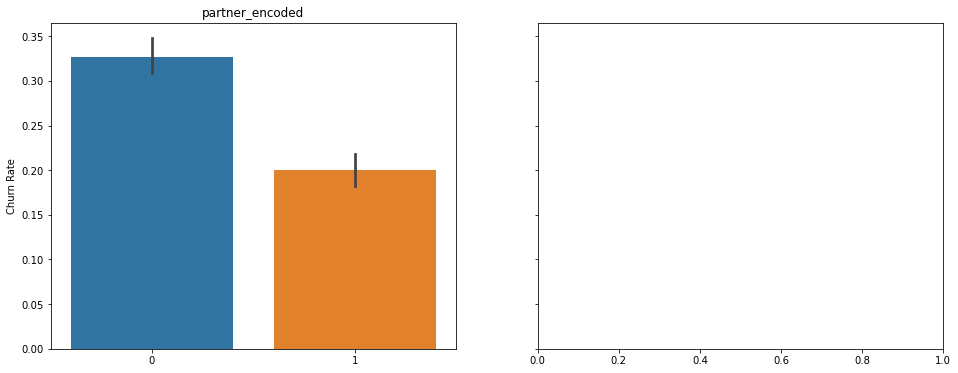

In [18]:
features = ['partner_encoded', 'dependents_encoded']
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways: 
    1. Those without dependents churn slightly more than those who have dependents.
    2. Those without partners tend to churn slightly more than those who have partners.
    3. What this says is that you are more likely to churn without a partner or dependent, but it is not significant. 

In [ ]:
features = ['gender_encoded', 'senior_citizen']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Gender doesn't seem to have an impact on churn as it is equal.
2. There is a significant increase in churn among senior citizens than non senior citizens.

In [ ]:
features = ['phone_service_encoded', 'multiple_lines', 'fiber_optic', 'internet_service_type_None']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Having phone service does not seem to impact churn.
2. The amount of phone lines do not seem to have an affect on churn.
3. There is a very significant churn with those who have fiber optic internet. 
4. There is a slightly significant churn among those without internet.

In [ ]:
features = ['paperless_billing_encoded', 'contract_type_One year', 'contract_type_Two year']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. There is a significant churn rate among those who are paperless billing.
2. There is a not really a churn among one or two year contracts, so that piece of info is not important for reason for churn.

In [ ]:
features = ['payment_type_Credit card (automatic)', 'electronic_check', 'payment_type_Mailed check']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways:

1. Credit card payments are not likely to churn.
2. Electronic checks have a very significant churn rate.
3. Mailed checks are not likely to churn.

In [ ]:
features = ['online_security', 'device_protection',  'online_backup', 'tech_support']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

# Takeaways: 
1. Those without online security churn significantly.
2. Those without device protection churn sifnificantly.
3. Those with no online backup churn significantly.
4. Those without tech support significantly churn more.

This is big, because this shows a theme. 

In [ ]:
# distribution of monthly charges
sns.displot(train, x=train.monthly_charges)

# Features (points of interest):

- senior citizen
- fiber_optic
- electronic_check
- paperless_billing_encoded
- online_security
- online_backup
- device_protection
- tech_support

In [ ]:
alpha = .05

# Senior Citizen

Hypothesis:

H0: Rate of churn is not dependent on being a senior citizen. 

H1: Rate of churn is dependent on being a senior citizen.

In [ ]:
observed1 = pd.crosstab(train.senior_citizen, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed1)

print('Observed\n')
print(observed1.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Fiber Optic Internet

H0: Churn is not dependent on having fiber optic internet.

H1: Churn is dependent on having fiber optic internet.

In [ ]:
observed2 = pd.crosstab(train.fiber_optic, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed2)

print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Electronic Check

H0: Churn is not dependent on electronic check payment type.

H1: Churn is dependent on electronic check payment type.

In [ ]:
observed3 = pd.crosstab(train.electronic_check, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed3)

print('Observed\n')
print(observed3.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Paperless Billing


H0: Churn is not dependent on if customer has paperless billing. 

H1: Churn is dependent on if customer has paperless billing.


In [ ]:
observed4 = pd.crosstab(train.paperless_billing_encoded, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed4)

print('Observed\n')
print(observed4.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Online Security

H0: Churn is not dependent on if a customer has online security.

H1: Churn is dependent on if a. customer has online security.

In [ ]:
observed5 = pd.crosstab(train.online_security, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed5)

print('Observed\n')
print(observed5.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Online Backup

H0: Churn is not dependent on if a customer has online backup.

H1: Churn is dependent on if a customer has online backup.

In [ ]:
observed6 = pd.crosstab(train.online_backup, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed6)

print('Observed\n')
print(observed6.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Device Protection

H0: Churn is not dependent on if a customer has device protection.

H1: Churn is dependent if a customer has device protection.

In [ ]:
observed7 = pd.crosstab(train.device_protection, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed7)

print('Observed\n')
print(observed7.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# Tech Support

H0: Churn is not dependent on if a customer receives tech support.

H1: Churn is dependent on if a customer receives tech support.

In [ ]:
observed8 = pd.crosstab(train.tech_support, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed8)

print('Observed\n')
print(observed8.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

# What this tells us:

All of these features reject null hypothesis so that means that they are not independent and in some way dependent to churn.

# Modeling


TP = Predict that a customer will churn and they do

TN = Predict that a customer will not churn and they do not

FP = Predict that a customer will churn but they do not

FN = Predict that a customer will not churn but they do

In [ ]:
# Need to drop because these original, non-encoded columns are strings and also duplicates so unneeded
columns_to_drop = ['partner', 'gender', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 
                  'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'churn_encoded', 'contract_type', 'internet_service_type', 'payment_type',
                  ]

In [ ]:
# create the object
X_train = train.drop(columns = columns_to_drop)
y_train = train.churn_encoded

X_validate = validate.drop(columns = columns_to_drop)
y_validate = validate.churn_encoded

X_test = test.drop(columns = columns_to_drop)
y_test = test.churn_encoded

# Setting up the baseline

In [ ]:
baseline = train.churn_encoded.mode()
baseline

In [ ]:
baseline = 0
baseline_accuracy = (train.churn_encoded == baseline).mean()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

# Decision Tree

## What I am looking for:

In this situation, I will be focusing mainly on my accuracy percentage. Reason being is because for this scenario, it is neither detrimental financially nor is it a life threatening situation. False positives and false negatives will not tank the company and neither is anyone in danger.

In [ ]:
# train
for i in range(1, 20):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
# validate
for i in range(1, 20):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    
    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_validate)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_validate, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
df = DecisionTreeClassifier(max_depth=6, random_state=123)

df.fit(X_train, y_train)

y_pred = df.predict(X_train)
y_pred_proba = df.predict_proba(X_train)

#evaluate metrics
print('Accuracy of model with all features in train set:', df.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

In [ ]:
y_pred = df.predict(X_validate)
y_pred_proba = df.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', df.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

I found that as I went lower in depth, the worse that train did and the higher I went, the worse validate did. Found a sweet spot with train at 82% accuracy and validate at 78% accuracy.

# Random Forrest

In [ ]:
# Train
for i in range(1, 20):
    # Make the model
    rf = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    rf = rf.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = rf.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Forest with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
# Validate 
for i in range(1, 20):
    # Make the model
    rf = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    rf = rf.fit(X_train, y_train)
    
    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = rf.predict(X_validate)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_validate, y_predictions, output_dict=True)
    print(f"Forest with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of model with all features in train set:', rf.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

In [ ]:
y_pred = rf.predict(X_validate)
y_pred_proba = rf.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', rf.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Found that with a max dept of 4, train is accurate 80% of the time and validate at 78%

# KNN

In [ ]:
# Train
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = knn.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f" KNN test with max neighbors of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
# Validate
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    
    # ONLY TRAINNNNN
    knn.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = knn.predict(X_validate)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_validate, y_predictions, output_dict=True)
    print(f" KNN test with max neighbors of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of model with all features in train set:', knn.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

In [ ]:
y_pred = knn.predict(X_validate)
y_pred_proba = knn.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', knn.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Decided that our best bet was neighbor = 15. Train does 80% validate does 78%

# Logistic Regression

In [ ]:
lr = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)

print('Accuracy of model with all features in train set:', lr.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

In [ ]:
y_pred = lr.predict(X_validate)
y_pred_proba = lr.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', lr.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

This one definitely did the worst, both really low at 33-34%

When deciding what to use for the test, it came very close for my Random Forrest and KNN module, as they're accuracy fell very close to one another.

In [ ]:
y_pred = rf.predict(X_validate)
y_pred_proba = rf.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', rf.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

In [ ]:
y_pred = knn.predict(X_validate)
y_pred_proba = knn.predict_proba(X_validate)

print('Accuracy of model with all features in validate set:', knn.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Both came to 78% accuracy, so we started to see where it did better in other places. I wanted to focus on prediction of False Negatives, as that would mean a customer would be predicted not to churn, but will, which I feel is important to keep track of. Based on that, I focused on their recall. So the decision came to using the KNN model, which beat Random Forrest with 41%, while Random Forrest was at 39%.

# Test

To recall, we are trying to see if our model can beat our baseline. 

In [ ]:
baseline = 0
baseline_accuracy = (train.churn_encoded == baseline).mean()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)
print('Accuracy of model with all features in train set:', knn.score(X_test, y_test))
print('\nThe confusion matrix:\n',confusion_matrix(y_test, y_pred))
print('\nClassification report:\n',classification_report(y_test, y_pred))

## Baseline accuracy was 73.43%

## My developed KNN test 79%

### Prepare Prediction CSV

In [ ]:
proba_test = knn.predict_proba(X_test)

In [ ]:
proba_df = pd.DataFrame(proba_test, columns=knn.classes_.tolist())
proba_df.head()

In [ ]:
reset_test = test.reset_index()
reset_test.head()

In [ ]:
test_proba_df = pd.concat([reset_test, proba_df], axis=1)
test_proba_df.head()

In [ ]:
test_proba_df['predicted'] = y_pred
test_proba_df.head()

In [ ]:
test_proba_df.info()

In [ ]:
csv_df = test_proba_df[['index', 0, 1, 'predicted']]
csv_df.head()

In [ ]:
# Write DataFrame to a csv file for deliverable.

csv_df.to_csv('predictions.csv')

# Conclusion:

move into final noteboook